## Linear Statistical Model
We recommend using linux for running the statistical model notebooks.

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.stats import rv_discrete, wasserstein_distance
from KDEpy import FFTKDE
from cv2 import EMD, DIST_L2
import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.data as utils_data
import torch.distributions as dist
import pickle
import kde_emd_proc as kep
from importlib import reload
import os
import sys

sys.path.append(os.path.abspath(os.path.join("..")))

import visual
import utils

pygame 2.5.2 (SDL 2.28.3, Python 3.12.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_device()

In [6]:
rgb_green = (17/255, 119/255, 51/255)
rgb_skyblue = (136/255, 204/255, 238/255)
rgb_magenta = (170/255, 68/255, 153/255)

# Load Human Data

In [7]:
human_data = pd.read_csv("../../../data/human_data/prediction/prediction_long.csv").drop("Unnamed: 0", axis=1)
human_data

,participant,order,trial,hole,world,click,response
0,1,41,1,1,2,1,124.5
1,1,41,1,1,2,2,124.5
2,1,41,1,1,2,3,124.5
3,1,41,1,1,2,4,124.5
4,1,41,1,1,2,5,124.5
...,...,...,...,...,...,...,...
53995,45,72,120,3,118,6,466.5
53996,45,72,120,3,118,7,466.5
53997,45,72,120,3,118,8,466.5
53998,45,72,120,3,118,9,466.5


In [8]:
human_means = human_data.groupby(["world", "hole"])["response"].agg(["mean"]).reset_index()
human_means

,world,hole,mean
0,2,1,124.936597
1,2,2,393.869930
2,2,3,497.323264
3,6,1,312.134375
4,6,2,309.229930
...,...,...,...
115,115,2,178.196597
116,115,3,482.972153
117,118,1,297.589930
118,118,2,305.621042


In [9]:
worlds = human_data["world"].unique()
worlds

array([  2,   6,   9,  10,  12,  13,  14,  16,  20,  26,  27,  32,  38,
        42,  45,  47,  48,  50,  56,  59,  62,  70,  74,  80,  82,  84,
        86,  90,  91,  92,  94,  99, 104, 105, 109, 111, 112, 113, 115,
       118])

In [10]:
human_kde_dict = kep.compute_kdes(human_data, "response")

# Gaussian Mixture

## Define Model

In [11]:
class linear_gmm(nn.Module):

    def __init__(self, hdim1, num_comp=10, drop_p=0, one_hot=True, lnorm=True):
        super().__init__()

        self.one_hot = one_hot
        if self.one_hot:
            inp_dim = 12
        else:
            inp_dim = 10

        moduls = []
        moduls.append(nn.LayerNorm(inp_dim))
        moduls.append(nn.Linear(inp_dim, hdim1))
        moduls.append(nn.Dropout(drop_p*0.5))
        
        last_dim = hdim1
        
        self.base_mdl = nn.Sequential( *moduls )

        self.a_out =     nn.Linear(last_dim, num_comp)
        self.mu_out =    nn.Linear(last_dim, num_comp)
        self.sigma_out = nn.Linear(last_dim, num_comp)

    def forward(self, x):

        inter_act = self.base_mdl(x)
        a = self.a_out(inter_act).softmax(dim=1)
        mu = self.mu_out(inter_act)
        sd = torch.nn.functional.softplus(self.sigma_out(inter_act)) + 1e-5
        return a, mu, sd

    def setup_distr(self,x):
        a, mu, sd = self(x)
        return self.get_distr(a,mu,sd)
    
    def get_distr(self, w, center, spread):
        mix = dist.Categorical(w)
        comp = dist.Normal(center, spread)
        return dist.MixtureSameFamily(mix, comp)



## Setup Data

In [12]:
def extract_features(shape):
    return shape["position"]["x"], shape["position"]["y"], shape["rotation"]

def create_feature_rep(exp_trial, world_num=None, world_rep=None, beta_scale=False, one_hot=True):

    if exp_trial:
        world_rep = utils.load_trial(world_num, experiment="prediction", hole=1)
    else:
        assert not (world_rep is None)
        
    world_rep_unity = visual.unity_transform_trial(world_rep)
    
    obstacles = world_rep_unity["obstacles"]
    tri = obstacles["triangle"]
    rect = obstacles["rectangle"]
    pent = obstacles["pentagon"]
    
    hole1_x, hole2_x, hole3_x = world_rep_unity["hole_positions"]
    tri_x, tri_y, tri_rot =     extract_features(tri)
    rect_x, rect_y, rect_rot =  extract_features(rect)
    pent_x, pent_y, pent_rot =  extract_features(pent)

    if beta_scale:
        hole1_x /= 600
        hole2_x /= 600
        hole3_x /= 600
        tri_x /= 600
        tri_y /= 600
        rect_x /= 600
        rect_y /= 600
        pent_x /= 600
        pent_y /= 600
    
    obstacles = [tri_x, tri_y, tri_rot,
                 rect_x, rect_y, rect_rot,
                 pent_x, pent_y, pent_rot]
    
    if one_hot:
        feature_rep = [
            [1.0, 0.0, 0.0] + obstacles,
            [0.0, 1.0, 0.0] + obstacles,
            [0.0, 0.0, 1.0] + obstacles
        ]
    else:
        feature_rep = [[hole1_x] + obstacles,
                       [hole2_x] + obstacles,
                       [hole3_x] + obstacles]
    
    return feature_rep


def create_data_arrays(df_data, beta_scale=False, one_hot=True):

    feature_reps_dict = {}

    for world_num in df_data["world"].unique():
        world_dict = {}
        tr_rep = create_feature_rep(True, world_num, beta_scale=beta_scale, one_hot=one_hot)
        for hole in [1,2,3]:
            world_dict[hole] = tr_rep[hole-1]
        feature_reps_dict[world_num] = world_dict

    input_list = []
    label_list = []

    for ind, row in df_data.iterrows():
        world_num = int(row["world"])
        hole = int(row["hole"])
        response = row["response"]

        if beta_scale:
            response /= 600
        
        tr_rep = feature_reps_dict[world_num][hole]

        input_list.append(tr_rep)
        label_list.append(response)

    input_np = np.array(input_list)
    label_np = np.array(label_list)

    return input_np, label_np

class MLPDataSet(utils_data.Dataset):

    def __init__(self, inputs, labels):

        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return self.inputs.shape[0]
    
    def __getitem__(self, idx):

        input = self.inputs[idx,:]
        if len(self.labels.shape) == 1:
            label = self.labels[idx]
        elif len(self.labels.shape) == 2:
            label = self.labels[idx,:]
        else:
            raise Exception("Labels invalid dimension")

        return input, label

In [13]:
# df_train_data = human_data[human_data["world"].isin(train_worlds)]
# df_valid_data = human_data[human_data["world"].isin(valid_worlds)]

def process_human_data(train_data, valid_data, beta_scale=True, one_hot=True):
    train_inputs_np, train_labels_np = create_data_arrays(train_data, beta_scale=beta_scale, one_hot=one_hot)
    valid_inputs_np, valid_labels_np = create_data_arrays(valid_data, beta_scale=beta_scale, one_hot=one_hot)
    return train_inputs_np, train_labels_np, valid_inputs_np, valid_labels_np


## Setup Model and Run Training Loop

In [14]:
np.random.seed(1)
torch.manual_seed(1)

In [15]:
def train_loop(model_type, model_kwargs, lrs,
               train_data, valid_data, process_data,
               batch_size=50, beta_scale=True,
               print_prog=False, n_epochs=100,
               init_model_path=None,
              ):
    data_tup = process_data(train_data, valid_data, beta_scale=beta_scale, one_hot=model_kwargs["one_hot"])
    train_input_np, train_label_np, valid_input_np, valid_label_np = data_tup
    print("train_input_np.shape")
    print(train_input_np[:5])
    print(train_input_np.shape)
    print("train_label_np.shape")
    print(train_label_np[:5])
    print(train_label_np.shape)
    
    train_input_torch = torch.from_numpy(train_input_np.astype(np.float32)).to(device)
    train_label_torch = torch.from_numpy(train_label_np.astype(np.float32)).to(device)
    
    valid_input_torch = torch.from_numpy(valid_input_np.astype(np.float32)).to(device)
    valid_label_torch = torch.from_numpy(valid_label_np.astype(np.float32)).to(device)
    
    train_ds = MLPDataSet(train_input_torch, train_label_torch)
    train_dl = utils_data.DataLoader(train_ds,
                                batch_size=batch_size,
                                shuffle=True)
    return_results = False
    results = dict()
    best_epoch = 0
    best_loss = np.inf
    for lr in lrs:
        try:
            print()
            print("New Training - LR:", lr)
            model = model_type(**kwargs)
            if init_model_path:
                checkpt = torch.load(init_model_path)
                model.load_state_dict(checkpt["state_dict"])
            model.to(device)
            
            optimizer = torch.optim.Adam(model.parameters(),
                                        lr = lr,
                                        weight_decay=0.01)
            train_loss_record = []
            valid_loss_record = []
            bpe = len(train_dl)
            train_n = len(train_ds)
            valid_n = valid_label_np.shape[0]
            
            for epoch in range(n_epochs):
                data_iter = iter(train_dl)
            
                model.train()
            
                train_epoch_loss = 0
            
                for i,(batch_inp, batch_lab) in enumerate(data_iter):
                    optimizer.zero_grad()
                    distr = model.setup_distr(batch_inp)
                    loss = -distr.log_prob(batch_lab).sum()
            
                    loss.backward()
                    optimizer.step()
            
                    train_epoch_loss += loss.item()
                    if print_prog:
                        print(round(100*(i/len(data_iter))), "%", end="          \r")
            
                
                train_loss_record.append(train_epoch_loss/train_n)
            
                model.eval()
            
                with torch.no_grad():
            
                    valid_distr = model.setup_distr(valid_input_torch)
                    valid_loss = -valid_distr.log_prob(valid_label_torch).sum().item()/valid_n
                    valid_loss_record.append(valid_loss)
            
                print("Epoch", epoch, "-- Loss", train_epoch_loss/train_n, "-- Val:", valid_loss)
                if valid_loss<best_loss:
                    best_loss = valid_loss
                    best_epoch = epoch
                    best_sd = model.state_dict()
                
        except KeyboardInterrupt as e:
            return_results = True
        results[lr] = {
            "model": model.cpu(),
            "best_model_sd": best_sd,
            "best_loss": best_loss,
            "best_epoch": best_epoch,
            "train_loss": train_loss_record,
            "val_loss": valid_loss_record,
            "model_kwargs": model_kwargs,
        }
        torch.cuda.empty_cache()
        if return_results:
            return results, data_tup
    return results, data_tup

# Beta Mixture

## Define Model

In [16]:
class linear_bmm(linear_gmm):
    def forward(self, x):
        inter_act = self.base_mdl(x)
        comp_weights = self.a_out(inter_act).softmax(dim=1)
        alpha = self.mu_out(inter_act).exp()
        beta = self.sigma_out(inter_act).exp()
        return comp_weights, alpha, beta

    def setup_distr(self, x):
        comp_weights, alpha, beta = self(x)
        return self.get_distr(comp_weights, alpha, beta)
    
    def get_distr(self, w, center, spread):
        mix = dist.Categorical(w)
        comp = dist.Beta(center, spread)
        return dist.MixtureSameFamily(mix, comp)


# BMM Physical Data

## Setup Pretraining Dataset

In [17]:
# inputs
with open("saved_sims/train_phys_worlds.pkl", "rb") as f:
    train_data = pickle.load(f)
    
with open("saved_sims/val_phys_worlds.pkl", "rb") as f:
    valid_data = pickle.load(f)

In [18]:
def process_sim_data(train_data, valid_data, beta_scale=True, one_hot=True):
    train_worlds = train_data
    valid_worlds = valid_data
    train_list = []
    train_labels = []
                               
    
    for i, world_rep in enumerate(train_worlds):
        feature_rep = create_feature_rep(False, world_rep=world_rep["world"], beta_scale=beta_scale, one_hot=one_hot)
        train_list += feature_rep
        train_labels += world_rep["final_positions"]
        
    train_inputs = np.array(train_list)
    
    
    valid_list = []
    valid_labels = []
    
    for i, world_rep in enumerate(valid_worlds):
        feature_rep = create_feature_rep(False, world_rep=world_rep["world"], beta_scale=beta_scale, one_hot=one_hot)
        valid_list += feature_rep
        valid_labels += world_rep["final_positions"]
        
    valid_inputs = np.array(valid_list)
    
    train_inputs_np = train_inputs.astype(np.float32)
    valid_inputs_np = valid_inputs.astype(np.float32)
    
    train_labels_flat = np.asarray(train_labels).flatten()/600
    valid_labels_flat = np.asarray(valid_labels).flatten()/600
    
    train_labels_np = train_labels_flat.astype(np.float32)
    valid_labels_np = valid_labels_flat.astype(np.float32)
    return train_inputs_np, train_labels_np, valid_inputs_np, valid_labels_np

## Pretrain the model

In [19]:
lrs = [5e-4, 1e-4, 1e-5, 1e-3, ]
model_type = linear_bmm
batch_size = 50
n_epochs = 20
beta_scale = True
kwargs = {
    #"hdim1": 1024,
    #"hdim2": 1024,
    #"hdim3": 2048,
    "hdim1": 2048,
    "num_comp": 10,
    "drop_p": 0.5,
    "lnorm": True,
    "one_hot": True,
}
    
results, data_tup = train_loop(
    model_type, kwargs, lrs,
    train_data=train_data,
    valid_data=valid_data,
    process_data=process_sim_data,
    batch_size=batch_size,
    beta_scale=beta_scale,
    print_prog=True,
    n_epochs=n_epochs,
)


train_input_np.shape
[[1.         0.         0.         0.41638404 0.27830413 3.4023209
  0.6541569  0.1113599  1.3394241  0.6365839  0.4402275  0.641705  ]
 [0.         1.         0.         0.41638404 0.27830413 3.4023209
  0.6541569  0.1113599  1.3394241  0.6365839  0.4402275  0.641705  ]
 [0.         0.         1.         0.41638404 0.27830413 3.4023209
  0.6541569  0.1113599  1.3394241  0.6365839  0.4402275  0.641705  ]
 [1.         0.         0.         0.6441152  0.26575196 4.4519715
  0.42768094 0.43520662 1.9727267  0.41638404 0.12265688 2.749358  ]
 [0.         1.         0.         0.6441152  0.26575196 4.4519715
  0.42768094 0.43520662 1.9727267  0.41638404 0.12265688 2.749358  ]]
(90000, 12)
train_label_np.shape
[0.25204894 0.17233917 0.5653031  0.25204894 0.60965157]
(90000,)

New Training - LR: 0.0005
Epoch 0 -- Loss -0.4050975703689787 -- Val: -0.5182861002604167
Epoch 1 -- Loss -0.5411368709829119 -- Val: -0.5956371744791666
Epoch 2 -- Loss -0.5750605227682326 -- Val: 

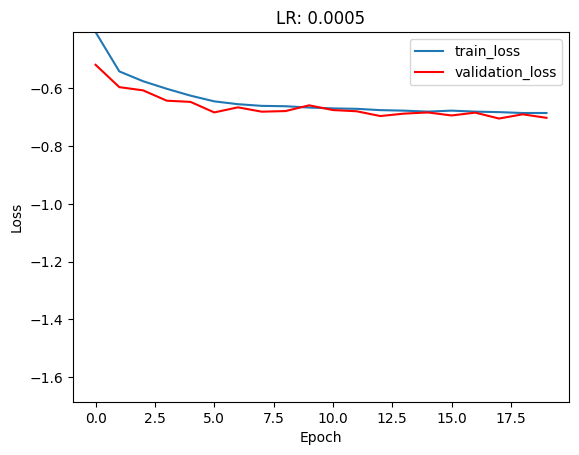

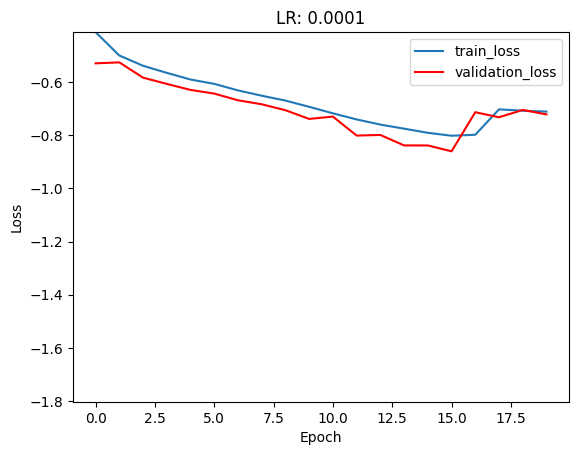

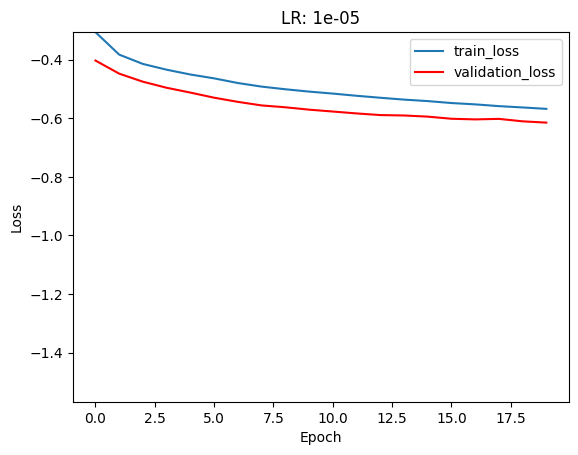

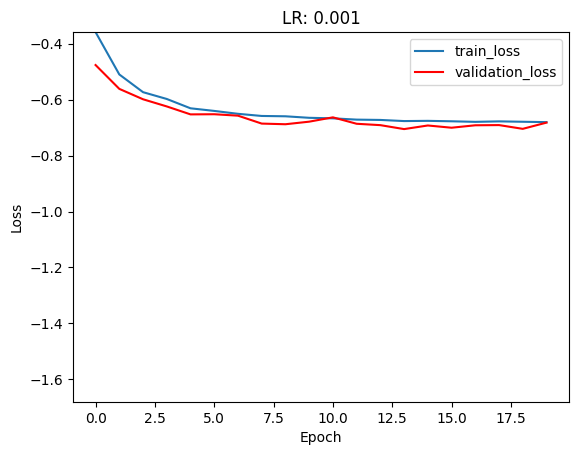

Best LR: 0.0001 -- Train Loss: -0.7116909366395738 -- Val Loss: -0.7220354817708333


In [20]:
best_lr = None
min_loss = np.inf
model = None
for lr, res in results.items(): 
    train_loss_record = res["train_loss"]
    valid_loss_record = res["val_loss"]
    plt.plot(range(len(train_loss_record)), train_loss_record, label="train_loss")
    plt.plot(range(len(valid_loss_record)), valid_loss_record, color="red", label="validation_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim([np.min(train_loss_record)-1,max(np.max(valid_loss_record), np.max(train_loss_record))])
    plt.title(f"LR: {lr}")
    plt.legend(loc="upper right")
    
    #plt.savefig("plots/mlp_bmm_loss_curve.jpg",
    #            dpi=200,
    #            bbox_inches="tight")
    plt.show()
    
    loss = valid_loss_record[-1]
    if loss<min_loss:
        best_lr = lr
        min_loss = loss
        model = results[lr]["model"]
        best_res = res
        
best_model_data = {
    "state_dict": model.state_dict(),
    "lr": best_lr,
    "train_loss": best_res["train_loss"],
    "val_loss": best_res["val_loss"],
    "model_kwargs": best_res["model_kwargs"],
}
torch.save(best_model_data, "nn_checkpoints/best_phys_linear_bmm.pth")

print("Best LR:", best_lr, "-- Train Loss:", results[best_lr]["train_loss"][-1], "-- Val Loss:", results[best_lr]["val_loss"][-1])

# Cross Validation

In [21]:
np.random.seed(1)
torch.manual_seed(1)

with open("cv_splits.pkl", "rb") as f:
    splits = pickle.load(f)

world_key = splits["key"]

keys = set(splits.keys())
keys.remove("key")
print("splits:")
for k in keys:
    print(k, splits[k].shape)

og_shapes = {k: splits[k].shape for k in keys}
flat_splits = {k: splits[k].reshape(-1) for k in keys}
world_num_splits = {
    k: np.asarray([world_key[i][1] for i in flat_splits[k]]) for k in keys
}
world_num_splits = {k: v.reshape(og_shapes[k]) for k,v in world_num_splits.items()}
print("\nworld num splits:")
for k in keys:
    print(k, world_num_splits[k].shape)
    
train_worlds = world_num_splits["train"]
valid_worlds = world_num_splits["test"]
test_worlds = world_num_splits["test"]

splits:
test (100, 20)
train (100, 20)

world num splits:
test (100, 20)
train (100, 20)


## Run Cross Val

In [22]:
lrs = [5e-4]
model_type = linear_bmm
batch_size = 50
beta_scale = True
n_epochs = 2
kwargs = {
    #"hdim1": 1024,
    #"hdim2": 1024,
    #"hdim3": 2048,
    "hdim1": 2048,
    "num_comp": 10,
    "drop_p": 0.5,
    "lnorm": True,
    "one_hot": True,
}

init_model_path = "nn_checkpoints/best_phys_linear_bmm.pth"
opt_epochs = []
opt_models = []
end_models = []

split = 0
for train_split, valid_split in zip(train_worlds, valid_worlds):

    print("Split:", split)
    print()

    df_train_data = human_data[human_data["world"].isin(train_split)]
    df_valid_data = human_data[human_data["world"].isin(valid_split)]

    results, data_tup = train_loop(
        model_type, kwargs, lrs,
        train_data=df_train_data,
        valid_data=df_valid_data,
        process_data=process_human_data,
        batch_size=batch_size,
        beta_scale=beta_scale,
        print_prog=True,
        n_epochs=n_epochs,
        init_model_path=init_model_path,
    )
    train_loss_record = results[lrs[0]]["train_loss"]
    valid_loss_record = results[lrs[0]]["val_loss"]

    model = results[lrs[0]]["model"]
    model.load_state_dict(results[lrs[0]]["best_model_sd"])

    min_epoch = min(list(enumerate(valid_loss_record)), key=lambda x: x[1])[0]

    end_models.append(model)
    opt_models.append(model)
    opt_epochs.append(min_epoch)

    split += 1

Split: 0

train_input_np.shape
[[1.         0.         0.         0.74071916 0.23876116 1.34516454
  0.26651275 0.22863646 4.39196146 0.73638002 0.60035772 2.02877568]
 [1.         0.         0.         0.74071916 0.23876116 1.34516454
  0.26651275 0.22863646 4.39196146 0.73638002 0.60035772 2.02877568]
 [1.         0.         0.         0.74071916 0.23876116 1.34516454
  0.26651275 0.22863646 4.39196146 0.73638002 0.60035772 2.02877568]
 [1.         0.         0.         0.74071916 0.23876116 1.34516454
  0.26651275 0.22863646 4.39196146 0.73638002 0.60035772 2.02877568]
 [1.         0.         0.         0.74071916 0.23876116 1.34516454
  0.26651275 0.22863646 4.39196146 0.73638002 0.60035772 2.02877568]]
(27000, 12)
train_label_np.shape
[0.10916667 0.10916667 0.10916667 0.10916667 0.10916667]
(27000,)

New Training - LR: 0.0005
Epoch 0 -- Loss -0.8111194478494149 -- Val: -0.11368144169560185
Epoch 1 -- Loss -0.9478731505782516 -- Val: 0.11505396412037038
Split: 1

train_input_np.sha

In [23]:
mlp_means = []
mlp_kde_dict = {}
results = []

x_values = torch.linspace(0.0001,0.9999,600).to(device).unsqueeze(1)

for test_split, model in zip(test_worlds, opt_models):

    model.to(device)
    model.eval()

    # Setup input for given split
    test_input_list = []
    for world_num in test_split:
        test_input_list += (create_feature_rep(True, world_num, beta_scale=True))
    test_input_np = np.array(test_input_list)

    test_input_torch = torch.tensor(test_input_np, dtype=torch.float32).to(device)

    # Get predictions and setup bmm
    test_comp_weights, test_alpha, test_beta = model(test_input_torch)
    test_bmm = model.get_distr(test_comp_weights, test_alpha, test_beta)

    # Get means
    test_bmm_means = test_bmm.mean.detach().cpu().numpy() * 600

    # Get pdf
    log_probs = test_bmm.log_prob(x_values)
    pdf = torch.exp(log_probs)/600
    pdf_np = pdf.cpu().detach().numpy().T

    mlp_means += list(zip(np.repeat(test_split, 3), test_bmm_means))
    split_kde = kep.make_kde_dict(pdf_np, test_split)

    mlp_kde_dict.update(split_kde)
    model.cpu()
    
    res_dict = {
        "test_bmm_means": test_bmm_means,
        "log_probs": log_probs.cpu().detach().data.numpy(),
        "pdf": pdf_np,
        "kde_dicts": split_kde,
    }
    results.append(res_dict)

with open("saved_model_pred/linear_w_pretraining_cvsplits.p", "wb") as f:
    pickle.dump(results, f)

mlp_means.sort(key=lambda x: x[0])

# All Data Runs

In [24]:
lrs = [5e-4]
model_type = linear_bmm
batch_size = 50
beta_scale = True
n_epochs = 2
kwargs = {
    #"hdim1": 1024,
    #"hdim2": 1024,
    #"hdim3": 2048,
    "hdim1": 2048,
    "num_comp": 10,
    "drop_p": 0.5,
    "lnorm": True,
    "one_hot": True,
}

init_model_path = "nn_checkpoints/best_phys_linear_bmm.pth"
opt_epochs = []
opt_models = []
end_models = []

split = 0
data_split = list(train_worlds[0]) + list(valid_worlds[0])
df_train_data = human_data[human_data["world"].isin(data_split)]
df_valid_data = human_data[human_data["world"].isin(valid_worlds[0])]

results, data_tup = train_loop(
    model_type, kwargs, lrs,
    train_data=df_train_data,
    valid_data=df_valid_data,
    process_data=process_human_data,
    batch_size=batch_size,
    beta_scale=beta_scale,
    print_prog=True,
    n_epochs=n_epochs,
    init_model_path=init_model_path,
)
train_loss_record = results[lrs[0]]["train_loss"]
valid_loss_record = results[lrs[0]]["val_loss"]

model = results[lrs[0]]["model"]
model.load_state_dict(results[lrs[0]]["best_model_sd"])

min_epoch = min(list(enumerate(valid_loss_record)), key=lambda x: x[1])[0]

end_models.append(model)
opt_models.append(model)
opt_epochs.append(min_epoch)

split += 1

train_input_np.shape
[[1.         0.         0.         0.74795107 0.58734024 4.52867207
  0.50867829 0.4238986  0.36917111 0.26072722 0.60903604 0.03528307]
 [1.         0.         0.         0.74795107 0.58734024 4.52867207
  0.50867829 0.4238986  0.36917111 0.26072722 0.60903604 0.03528307]
 [1.         0.         0.         0.74795107 0.58734024 4.52867207
  0.50867829 0.4238986  0.36917111 0.26072722 0.60903604 0.03528307]
 [1.         0.         0.         0.74795107 0.58734024 4.52867207
  0.50867829 0.4238986  0.36917111 0.26072722 0.60903604 0.03528307]
 [1.         0.         0.         0.74795107 0.58734024 4.52867207
  0.50867829 0.4238986  0.36917111 0.26072722 0.60903604 0.03528307]]
(54000, 12)
train_label_np.shape
[0.2075 0.2075 0.2075 0.2075 0.2075]
(54000,)

New Training - LR: 0.0005
Epoch 0 -- Loss -0.7515596740863941 -- Val: -0.8940164207175926
Epoch 1 -- Loss -0.8468130889468722 -- Val: -0.9424730179398149


In [25]:
mlp_means = []
mlp_kde_dict = {}
results = []

x_values = torch.linspace(0.0001,0.9999,600).to(device).unsqueeze(1)

test_split = sorted(data_split)

model.to(device)
model.eval()

# Setup input for given split
test_input_list = []
for world_num in test_split:
    test_input_list += (create_feature_rep(True, world_num, beta_scale=True))
test_input_np = np.array(test_input_list)

test_input_torch = torch.tensor(test_input_np, dtype=torch.float32).to(device)

# Get predictions and setup bmm
test_comp_weights, test_alpha, test_beta = model(test_input_torch)
test_bmm = model.get_distr(test_comp_weights, test_alpha, test_beta)

# Get means
test_bmm_means = test_bmm.mean.detach().cpu().numpy() * 600

# Get pdf
log_probs = test_bmm.log_prob(x_values)
pdf = torch.exp(log_probs)/600
pdf_np = pdf.cpu().detach().numpy().T

mlp_means += list(zip(np.repeat(test_split, 3), test_bmm_means))
split_kde = kep.make_kde_dict(pdf_np, test_split)

mlp_kde_dict.update(split_kde)
model.cpu()

res_dict = {
    "test_bmm_means": test_bmm_means,
    "log_probs": log_probs.cpu().detach().data.numpy(),
    "pdf": pdf_np,
    "kde_dicts": split_kde,
}
results.append(res_dict)

save_path = "saved_model_pred/linear_w_pretraining_alldata.p"
with open(save_path, "wb") as f:
    pickle.dump(results, f)
print("Saved to", save_path)

mlp_means.sort(key=lambda x: x[0])

Saved to saved_model_pred/linear_w_pretraining_alldata.p


In [26]:
_, mlp_mean_vals = zip(*mlp_means)

r = np.round(np.corrcoef(human_means["mean"], mlp_mean_vals)[0,1], decimals=2)
rmse = np.round(root_mean_squared_error(human_means["mean"], mlp_mean_vals), decimals=2)

print("r:", r)
print("RMSE:", rmse)

r: 0.94
RMSE: 42.48


Text(9, 535, 'RMSE = 42.48')

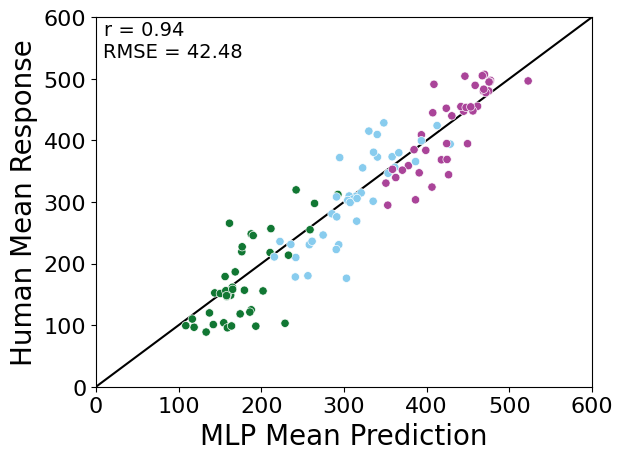

In [27]:
means_dict = {
    "human": human_means["mean"].to_numpy(),
    "mlp": mlp_mean_vals,
    "hole": [1,2,3]*40
}

df_to_show = pd.DataFrame(means_dict)

# plt.scatter(human_means["mean"], mlp_mean_vals)
plt.plot([0,600], [0,600], color="black", zorder=1)
sns.scatterplot(data=df_to_show,
                x="mlp", 
                y="human", 
                hue="hole", 
                palette=[rgb_green, rgb_skyblue, rgb_magenta])



plt.xlabel("MLP Mean Prediction", fontsize=20)
plt.ylabel("Human Mean Response", fontsize=20)

plt.xlim(0,600)
plt.ylim(0,600)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# remove the legend
plt.legend([],[], frameon=False)

# plt.legend(title = "hole",
#            loc="lower right",
#            fontsize=14)

# plt.setp(plt.gca().get_legend().get_title(), fontsize=14)

plt.text(10, 570, f"r = {r}", fontsize=14)
plt.text(9, 535, f"RMSE = {rmse}", fontsize=14)

#plt.savefig("plots/bmm_mean_scatter_full_data.jpg",
#            dpi=300,
#            bbox_inches="tight")

In [28]:
df_mlp_emd = kep.compute_emds(mlp_kde_dict, human_kde_dict, worlds)

In [29]:
print("Mean:", round(df_mlp_emd["EMD"].mean(),2))
print()
print("Quantiles:")
print(df_mlp_emd["EMD"].quantile([0.05, 0.95]).round(decimals=2))

Mean: 38.77

Quantiles:
0.05     9.37
0.95    83.72
Name: EMD, dtype: float64


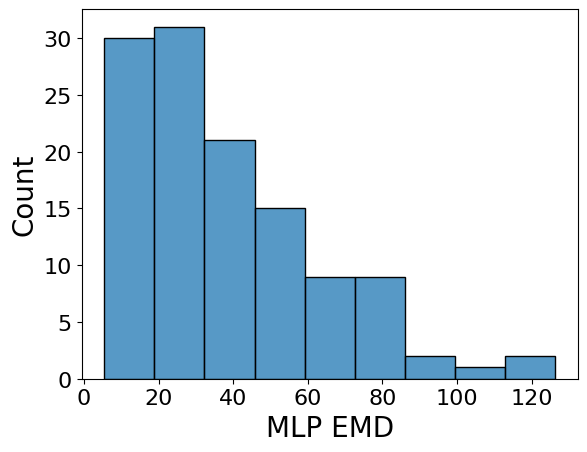

In [30]:
sns.histplot(data=df_mlp_emd, x="EMD")

plt.xlabel("MLP EMD", fontsize=20)
plt.ylabel("Count", fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# remove the legend
plt.legend([],[], frameon=False)